# Imports

In [1]:
!tar xf review_polarity.tar.gz

In [2]:
pospath = 'txt_sentoken/pos'
negpath = 'txt_sentoken/neg'

In [3]:
import pandas as pd
import numpy as np
import os 
import nltk
from collections import Counter
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocesamiento

## Funciones

In [5]:
# Funciones para tratar con los archivos en bruto

#Funcion para abrir el archivo txt
def openfile(archivo):
  file = open(archivo,'r')
  content = file.read()
  file.close()
  return content

#Funcion para tokenizar el archivo txt
def cleanfile(archivo, language):
  words = stopwords.words(language)
  table = str.maketrans(dict.fromkeys(string.punctuation))
  archivo =  archivo.translate(table)
  archivo = archivo.split()
  tokenarr = [word for word in archivo   if word.isalpha()]
  tokenarr = [word for word in tokenarr if word not in words] 
  tokenarr = [word for word in tokenarr if len(word)>1]
  return tokenarr 

#Funcion que implementa ambos y crea el arreglo con cuentas
def processfile(directory, abc, language):
  for archivo in os.listdir(directory): 
    archivo =  openfile(os.path.join(directory,archivo))
    tokenarr = cleanfile(archivo, language)
    abc.update(tokenarr)

# Funciones para tratar con el archivo limpio y tokenizado
#Funcion que tokeniza el archivo tomando en cuenta los tokens extraidos anteriormente
def cleanTokenFile(archivo, abc, language):
  words = stopwords.words(language)
  table = str.maketrans(dict.fromkeys(string.punctuation))
  archivo =  archivo.translate(table)
  archivo = archivo.split()
  tokenarr = [word for word in archivo   if word.isalpha()]
  tokenarr = [word for word in tokenarr if word not in words]
  tokenarr = [word for word in tokenarr if len(word)>1]
  tokenarr = [word for word in tokenarr if word in abc]
  return tokenarr 

#Funcion que procesa el arhivo y crea una lista de los tokens de cada doc
def processTokenFile(directory, abc, language):
  docs = list()
  for filename in os.listdir(directory):
    archivo =  openfile(os.path.join(directory,filename))
    tokenarr = cleanTokenFile(archivo,abc,language)
    lines = ' '.join(tokenarr)
    docs.append(lines)
  return docs

## Limpieza y preparación del documento final para el modelo

In [6]:
#Number of times words should appear to be kept
min_occurence = 2

In [7]:
abc = Counter()

pos_tokens = processfile(pospath, abc, 'english')
neg_tokens = processfile(negpath, abc, 'english')

#Check the most common words
abc.most_common(10)

[('film', 8860),
 ('one', 5521),
 ('movie', 5440),
 ('like', 3553),
 ('even', 2555),
 ('good', 2320),
 ('time', 2283),
 ('story', 2118),
 ('films', 2102),
 ('would', 2042)]

In [8]:
#Create the token array using the threshold we defined earlier
tokens = [k for k,v in abc.items() if v>=min_occurence]

In [9]:
#Save the tokens to a new txt file
data = '\n'.join(tokens)
file = open('tokens.txt','w')
file.write(data)
file.close()

In [10]:
#Open the file with the tokens to just extract those now
abcPost = openfile('tokens.txt')
abcSplitUnique = set(abcPost.split())
abcSplitUnique 

{'whoopee',
 'ennui',
 'suture',
 'rearrange',
 'purse',
 'grandmother',
 'posted',
 'holdup',
 'tapes',
 'ansell',
 'stillliving',
 'inconsistency',
 'brick',
 'stench',
 'wordofmouth',
 'incest',
 'multiplies',
 'investigations',
 'cadaverous',
 'beheadings',
 'regime',
 'shares',
 'bees',
 'brody',
 'worldview',
 'outgrown',
 'accessibility',
 'disco',
 'megan',
 'randys',
 'sonyloews',
 'cholodenkos',
 'insert',
 'cong',
 'contemplates',
 'isabelle',
 'obsessive',
 'moviemaker',
 'highway',
 'brothers',
 'obsessively',
 'decadent',
 'mishandle',
 'spindly',
 'vet',
 'manhunt',
 'save',
 'yglesias',
 'copping',
 'argument',
 'exploding',
 'illuminati',
 'kickoff',
 'connoisseurs',
 'raja',
 'garbage',
 'kint',
 'laughter',
 'colors',
 'concentrating',
 'duchovny',
 'welcomed',
 'minimum',
 'surgical',
 'marseilles',
 'titled',
 'humorous',
 'lois',
 'drix',
 'pic',
 'depalma',
 'dancer',
 'insects',
 'winters',
 'nowadays',
 'exasperating',
 'cabin',
 'incapacitated',
 'schoolers',


In [11]:
#Extract positive and negative
pos =  processTokenFile(pospath,abcSplitUnique ,'english')
neg =  processTokenFile(negpath,abcSplitUnique ,'english')

In [12]:
#Documento con los labels de clasificación
documento = pos+ neg 
#Labels de 1 a los positivos y de 0 a los negativos
labels = [1]* len(pos) + [0]*len(neg)
#Asegurarnos de que el número de labels es el mismo que de observaciones
try:
  assert len(labels) == len(pos)+len(pos)
  print('El número de labels encaja con el de observaciones')
except:
  print('El número de labels no encaja con el de observaciones')

El número de labels encaja con el de observaciones


In [13]:
#Codificar
tokenizer = Tokenizer()
tokenizer.fit_on_texts(documento)
tokens = tokenizer.texts_to_sequences(documento)
#Longitud del documento
length = max([len(i.split()) for i in documento])
padded = pad_sequences(tokens,length,padding='post')
#Crear los numpy arrays para entrenar el modelo
paddedArr = np.array(padded)
labelsArr = np.array(labels)

# Modelo

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
paddedArrTrain, paddedArrTest, labelsArrTrain, labelsArrTest = train_test_split(paddedArr, labelsArr, test_size=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1319, 100)         2714000   
                                                                 
 conv1d_1 (Conv1D)           (None, 1312, 32)          25632     
                                                                 
 dropout_6 (Dropout)         (None, 1312, 32)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 437, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 13984)             0         
                                                                 
 dense_6 (Dense)             (None, 4196)              58681060  
                                                      

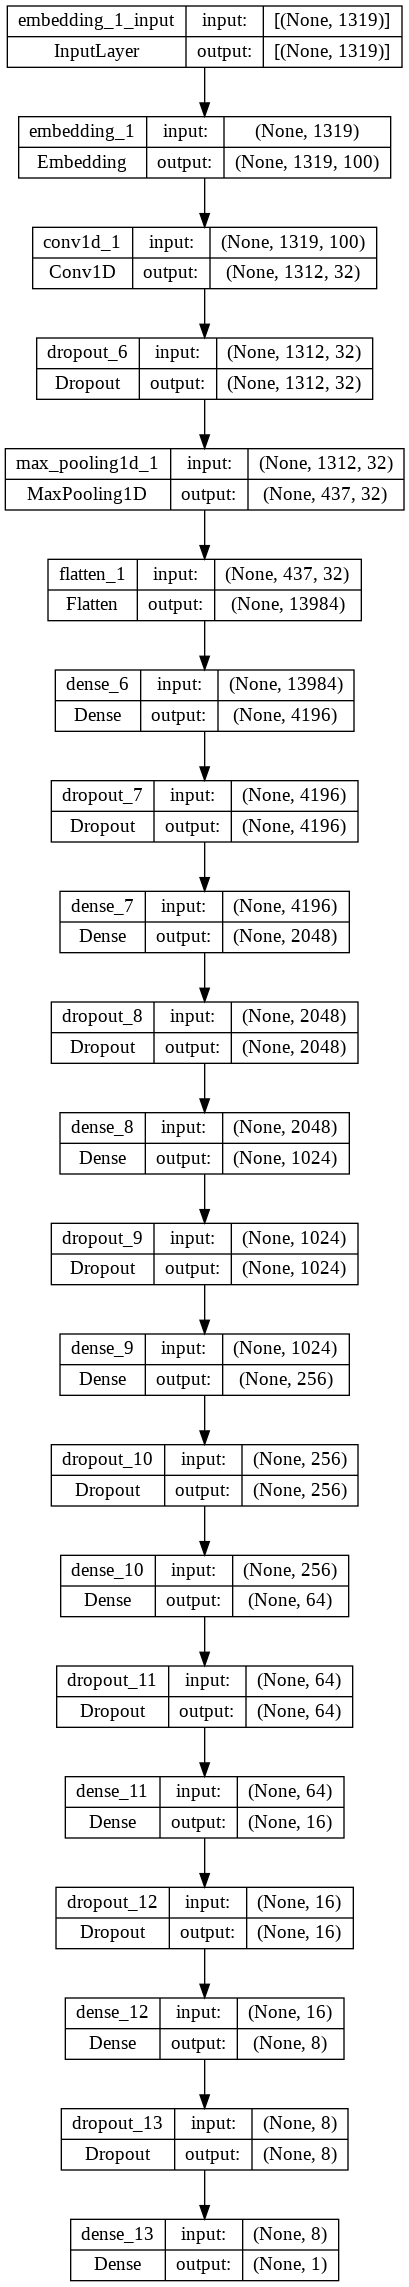

In [22]:
model = Sequential() 
model.add(Embedding(len(tokenizer.word_index) + 1,100,input_length=length))
model.add(Conv1D(32,kernel_size=8,activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(4196,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary() 
plot_model(model,to_file='model.png',show_shapes=True)

In [23]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#Con varias pruebas, parecía haber overfitting considerable después de la época 10 sin subir la presición de validación
history = model.fit(paddedArrTrain,
                    labelsArrTrain,
                    epochs=10,
                    batch_size=50,
                    validation_split = 0.2)

history_dict = history.history
history_dict.keys()

Epoch 1/10
26/26 [==============================] - 21s 760ms/step - loss: 0.7412 - accuracy: 0.4969 - val_loss: 0.6924 - val_accuracy: 0.5188
Epoch 2/10
26/26 [==============================] - 19s 724ms/step - loss: 0.6937 - accuracy: 0.5258 - val_loss: 0.6932 - val_accuracy: 0.5125
Epoch 3/10
26/26 [==============================] - 19s 723ms/step - loss: 0.6928 - accuracy: 0.5406 - val_loss: 0.6929 - val_accuracy: 0.4938
Epoch 4/10
26/26 [==============================] - 19s 729ms/step - loss: 0.6705 - accuracy: 0.5406 - val_loss: 0.6823 - val_accuracy: 0.4875
Epoch 5/10
26/26 [==============================] - 19s 724ms/step - loss: 0.5389 - accuracy: 0.7414 - val_loss: 0.7167 - val_accuracy: 0.6531
Epoch 6/10
26/26 [==============================] - 19s 725ms/step - loss: 0.3907 - accuracy: 0.9266 - val_loss: 0.8553 - val_accuracy: 0.6594
Epoch 7/10
26/26 [==============================] - 19s 732ms/step - loss: 0.3308 - accuracy: 0.9586 - val_loss: 0.7699 - val_accuracy: 0.7063

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
#Evaluar el modelo en el set de test
test_loss, test_acc = model.evaluate(paddedArrTest, labelsArrTest)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

13/13 [==============================] - 2s 117ms/step - loss: 1.0088 - accuracy: 0.7575
test_acc: 0.7574999928474426
test_loss: 1.0087586641311646
